In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import scanpy as sc
import anndata
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
adata_rna = sc.read_h5ad('/hpc/mydata/siyu.he/coral_storage/Data_SpatialGlue/Dataset13_Simulation1/adata_RNA.h5ad')
adata_adt = sc.read_h5ad('/hpc/mydata/siyu.he/coral_storage/Data_SpatialGlue/Dataset13_Simulation1/adata_ADT.h5ad')

Text(0, 0.5, '')

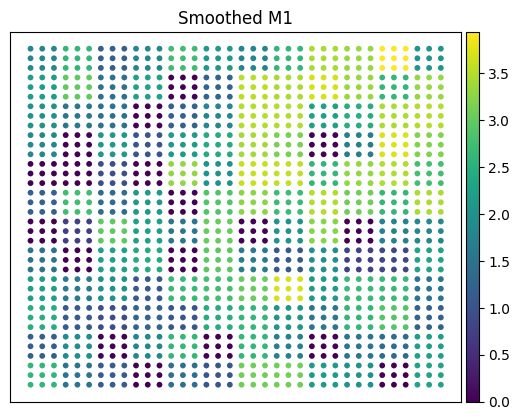

In [4]:
def smooth_spatial_data(adata_, norm_spatial, block_size=3):  # 0.08333 ~= 3/36
    n_blocks = 12
    smoothed_data = adata_.X.copy()
    for i in range(n_blocks):  
        for j in range(n_blocks):  
            
            min_x, max_x = i / n_blocks, (i + 1) / n_blocks
            min_y, max_y = j / n_blocks, (j + 1) / n_blocks
        
            block_indices = np.where(
                (norm_spatial[:, 0] >= min_x) & (norm_spatial[:, 0] <= max_x) &
                (norm_spatial[:, 1] >= min_y) & (norm_spatial[:, 1] <= max_y)
            )[0]
            
            if len(block_indices) > 0:
                block_data = adata_.X[block_indices]
                mean_data = block_data.mean(axis=0)
                smoothed_data[block_indices] = mean_data
    
    return smoothed_data
list_ = ['factor1','factor2','factor3','factor4','backgr']

adata = adata_rna.copy()
spatial_data = adata.obsm['spatial']
min_coord = spatial_data.min(axis=0)
max_coord = spatial_data.max(axis=0)
norm_spatial = (spatial_data - min_coord) / (max_coord - min_coord)

new_data = smooth_spatial_data(adata, norm_spatial)


# Create a new AnnData object for the downsampled data
adata_smoothed = sc.AnnData(X=new_data)
adata_smoothed.obsm['spatial'] = spatial_data

# Preprocess the downsampled data (e.g., normalization, PCA)
sc.pp.normalize_total(adata_smoothed, target_sum=1e4)
sc.pp.log1p(adata_smoothed)
sc.tl.pca(adata_smoothed, svd_solver='arpack')
sc.pp.neighbors(adata_smoothed, n_neighbors=260, n_pcs=50)
sc.tl.leiden(adata_smoothed, resolution=1e-3)

annotation_mapping = {
    '0': 'factor1',
    '1': 'factor2',
    '2': 'factor3',
    '3': 'factor4',
    '4': 'backgr'  
}
adata_smoothed.obs['cluster'] = adata_smoothed.obs['leiden'].map(annotation_mapping)
adata_smoothed.obs['cluster']  = pd.Categorical(adata_smoothed.obs['cluster'], 
                      categories=list_,
                      ordered=True)
adata_smoothed.obs['gene'] = adata_smoothed.to_df().iloc[:,0]

custom_palette = ['#e07a5f', '#f2cc8f', '#81b29a', '#3d405b', '#f4f1de']

sc.pl.embedding(adata_smoothed, basis='spatial', title='Smoothed M1', color='gene', s=70, show=False,palette=custom_palette)
plt.xlabel('')
plt.ylabel('')

In [3]:
import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
import muon
import scanpy as sc
import scvi
import time

t = time.time()
scvi.settings.seed = 1234

[rank: 0] Seed set to 1234


In [4]:
sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [5]:
adata_rna.obs['batch'] = 'simulation'
adata_rna.layers['counts'] = adata_rna.X.copy()

In [6]:

mdata = md.MuData({"rna": adata_rna, "protein": adata_adt})
mdata



/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 1296 × 1100
  2 modalities
    rna:	1296 x 1000
      obs:	'batch'
      uns:	'log1p'
      obsm:	'nsfac', 'spatial', 'spfac'
      varm:	'nsload', 'spload'
      layers:	'counts'
    protein:	1296 x 100
      uns:	'log1p'
      obsm:	'nsfac', 'spatial', 'spfac'
      varm:	'nsload', 'spload'
      layers:	'counts'

In [7]:
sc.pp.highly_variable_genes(
    mdata.mod["rna"],
    n_top_genes=4000,
    #flavor="seurat_v3",
    batch_key="batch",
    layer="counts",
)
# Place subsetted counts in a new modality
mdata.mod["rna_subset"] = mdata.mod["rna"][
    :, mdata.mod["rna"].var["highly_variable"]
].copy()

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/_utils/__init__.py:545: RuntimeWarning: overflow encountered in multiply
  return x * y
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


In [8]:
mdata

MuData object with n_obs × n_vars = 1296 × 1100
  3 modalities
    rna:	1296 x 1000
      obs:	'batch'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'log1p', 'hvg'
      obsm:	'nsfac', 'spatial', 'spfac'
      varm:	'nsload', 'spload'
      layers:	'counts'
    protein:	1296 x 100
      uns:	'log1p'
      obsm:	'nsfac', 'spatial', 'spfac'
      varm:	'nsload', 'spload'
      layers:	'counts'
    rna_subset:	1296 x 1000
      obs:	'batch'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'log1p', 'hvg'
      obsm:	'nsfac', 'spatial', 'spfac'
      varm:	'nsload', 'spload'
      layers:	'counts'

In [9]:
mdata.update()

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


In [10]:
mdata

MuData object with n_obs × n_vars = 1296 × 2100
  3 modalities
    rna:	1296 x 1000
      obs:	'batch'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'log1p', 'hvg'
      obsm:	'nsfac', 'spatial', 'spfac'
      varm:	'nsload', 'spload'
      layers:	'counts'
    protein:	1296 x 100
      uns:	'log1p'
      obsm:	'nsfac', 'spatial', 'spfac'
      varm:	'nsload', 'spload'
      layers:	'counts'
    rna_subset:	1296 x 1000
      obs:	'batch'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns:	'log1p', 'hvg'
      obsm:	'nsfac', 'spatial', 'spfac'
      varm:	'nsload', 'spload'
      layers:	'counts'

In [11]:
scvi.model.TOTALVI.setup_mudata(
    mdata,
    rna_layer="counts",
    protein_layer=None,
    batch_key="batch",
    modalities={
        "rna_layer": "rna_subset",
        "protein_layer": "protein",
        "batch_key": "rna_subset",
    },
)

In [12]:
vae = scvi.model.TOTALVI(mdata)

INFO     Computing empirical prior initialization for protein background.                                          


In [13]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/lightning/pytorch/core/optimizer.py:314: The lr s

Epoch 400/400: 100%|██████████| 400/400 [00:26<00:00, 15.12it/s, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.63e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:26<00:00, 15.14it/s, v_num=1, train_loss_step=1.63e+3, train_loss_epoch=1.63e+3]


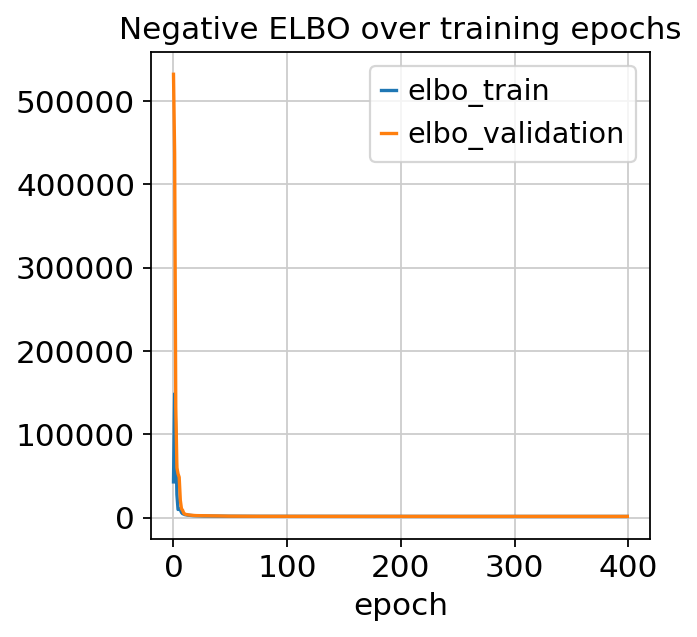

In [14]:
fig, ax = plt.subplots(1, 1)
vae.history["elbo_train"].plot(ax=ax, label="train")
vae.history["elbo_validation"].plot(ax=ax, label="validation")
ax.set(title="Negative ELBO over training epochs",)
ax.legend()

In [15]:
rna = mdata.mod["rna_subset"]
protein = mdata.mod["protein"]
# arbitrarily store latent in rna modality
TOTALVI_LATENT_KEY = "X_totalVI"
rna.obsm[TOTALVI_LATENT_KEY] = vae.get_latent_representation()

rna_denoised, protein_denoised = vae.get_normalized_expression(
    n_samples=25, return_mean=True, transform_batch=["simulation"]
)
rna.layers["denoised_rna"] = rna_denoised
protein.layers["denoised_protein"] = protein_denoised

protein.layers["protein_foreground_prob"] = 100 * vae.get_protein_foreground_probability(
    n_samples=25, return_mean=True, transform_batch=["simulation"]
)
parsed_protein_names = [p.split("_")[0] for p in protein.var_names]
protein.var["clean_names"] = parsed_protein_names
mdata.update()

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def cluster_latent_rep(latent_rep, n_clusters=5):
    scaler = StandardScaler()
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(latent_rep)
    return clusters
clusters = cluster_latent_rep(vae.get_latent_representation(), n_clusters=5)
rna.obs['cluster'] =clusters
rna.obs['cluster'] = rna.obs['cluster'].astype('category')


/tmp/ipykernel_3266655/1645814822.py:14: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(rna, resolution=0.01)


<Axes: title={'center': 'SpatialGlue'}, xlabel='spatial1', ylabel='spatial2'>

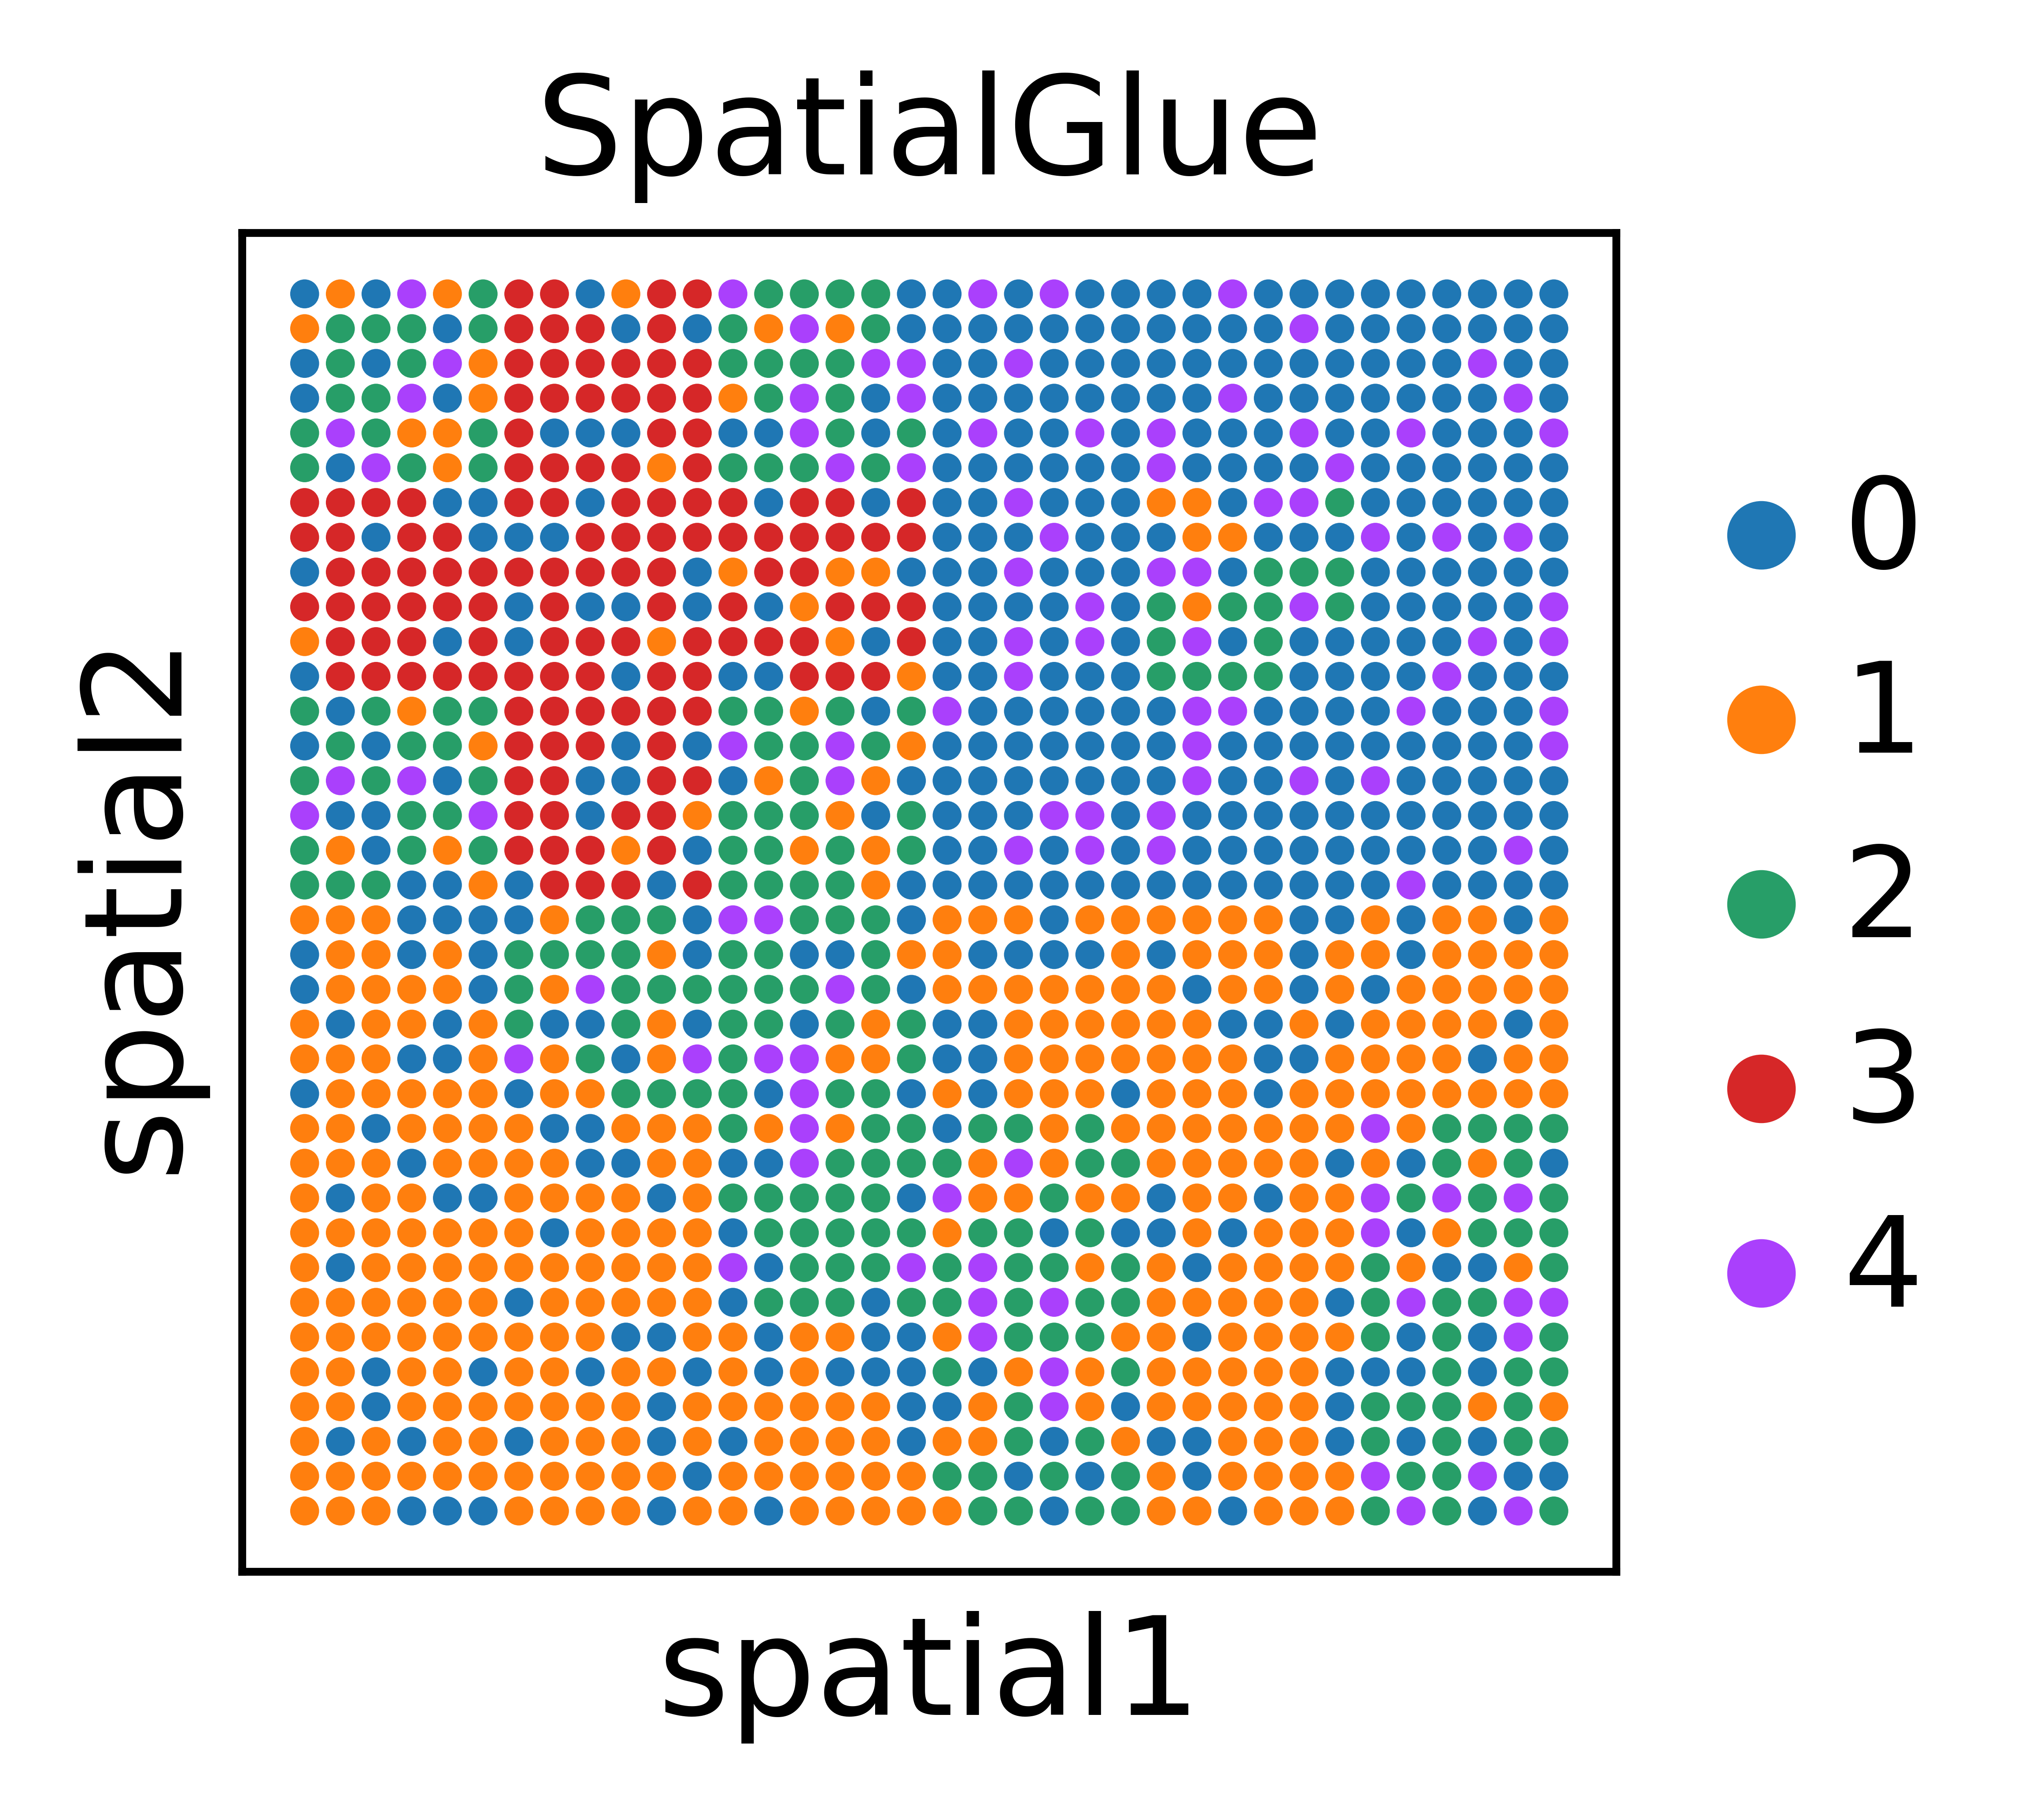

In [18]:
plt.rcParams['figure.figsize'] = (2.5,2.5)
plt.rcParams['font.size'] = 15
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['figure.dpi'] = 800

TOTALVI_CLUSTERS_KEY = "leiden_totalVI"

#sc.pp.neighbors(rna, use_rep=TOTALVI_LATENT_KEY)
#sc.tl.umap(rna)
#sc.tl.leiden(rna, key_added=TOTALVI_CLUSTERS_KEY)

#sc.pp.scale(adata)
sc.pp.neighbors(rna, use_rep=TOTALVI_LATENT_KEY)
sc.tl.leiden(rna, resolution=0.01)


In [36]:
custom_palette = ['#81b29a',  '#f2cc8f', '#f4f1de', '#3d405b','#e07a5f',]
annotation_mapping = {
    '0': 'factor1',
    '1': 'factor2',
    '2': 'factor3',
    '3': 'factor4',
    '4': 'backgr'  
}

rna.obs['leiden'] = rna.obs['leiden'].map(annotation_mapping)


Text(0, 0.5, '')

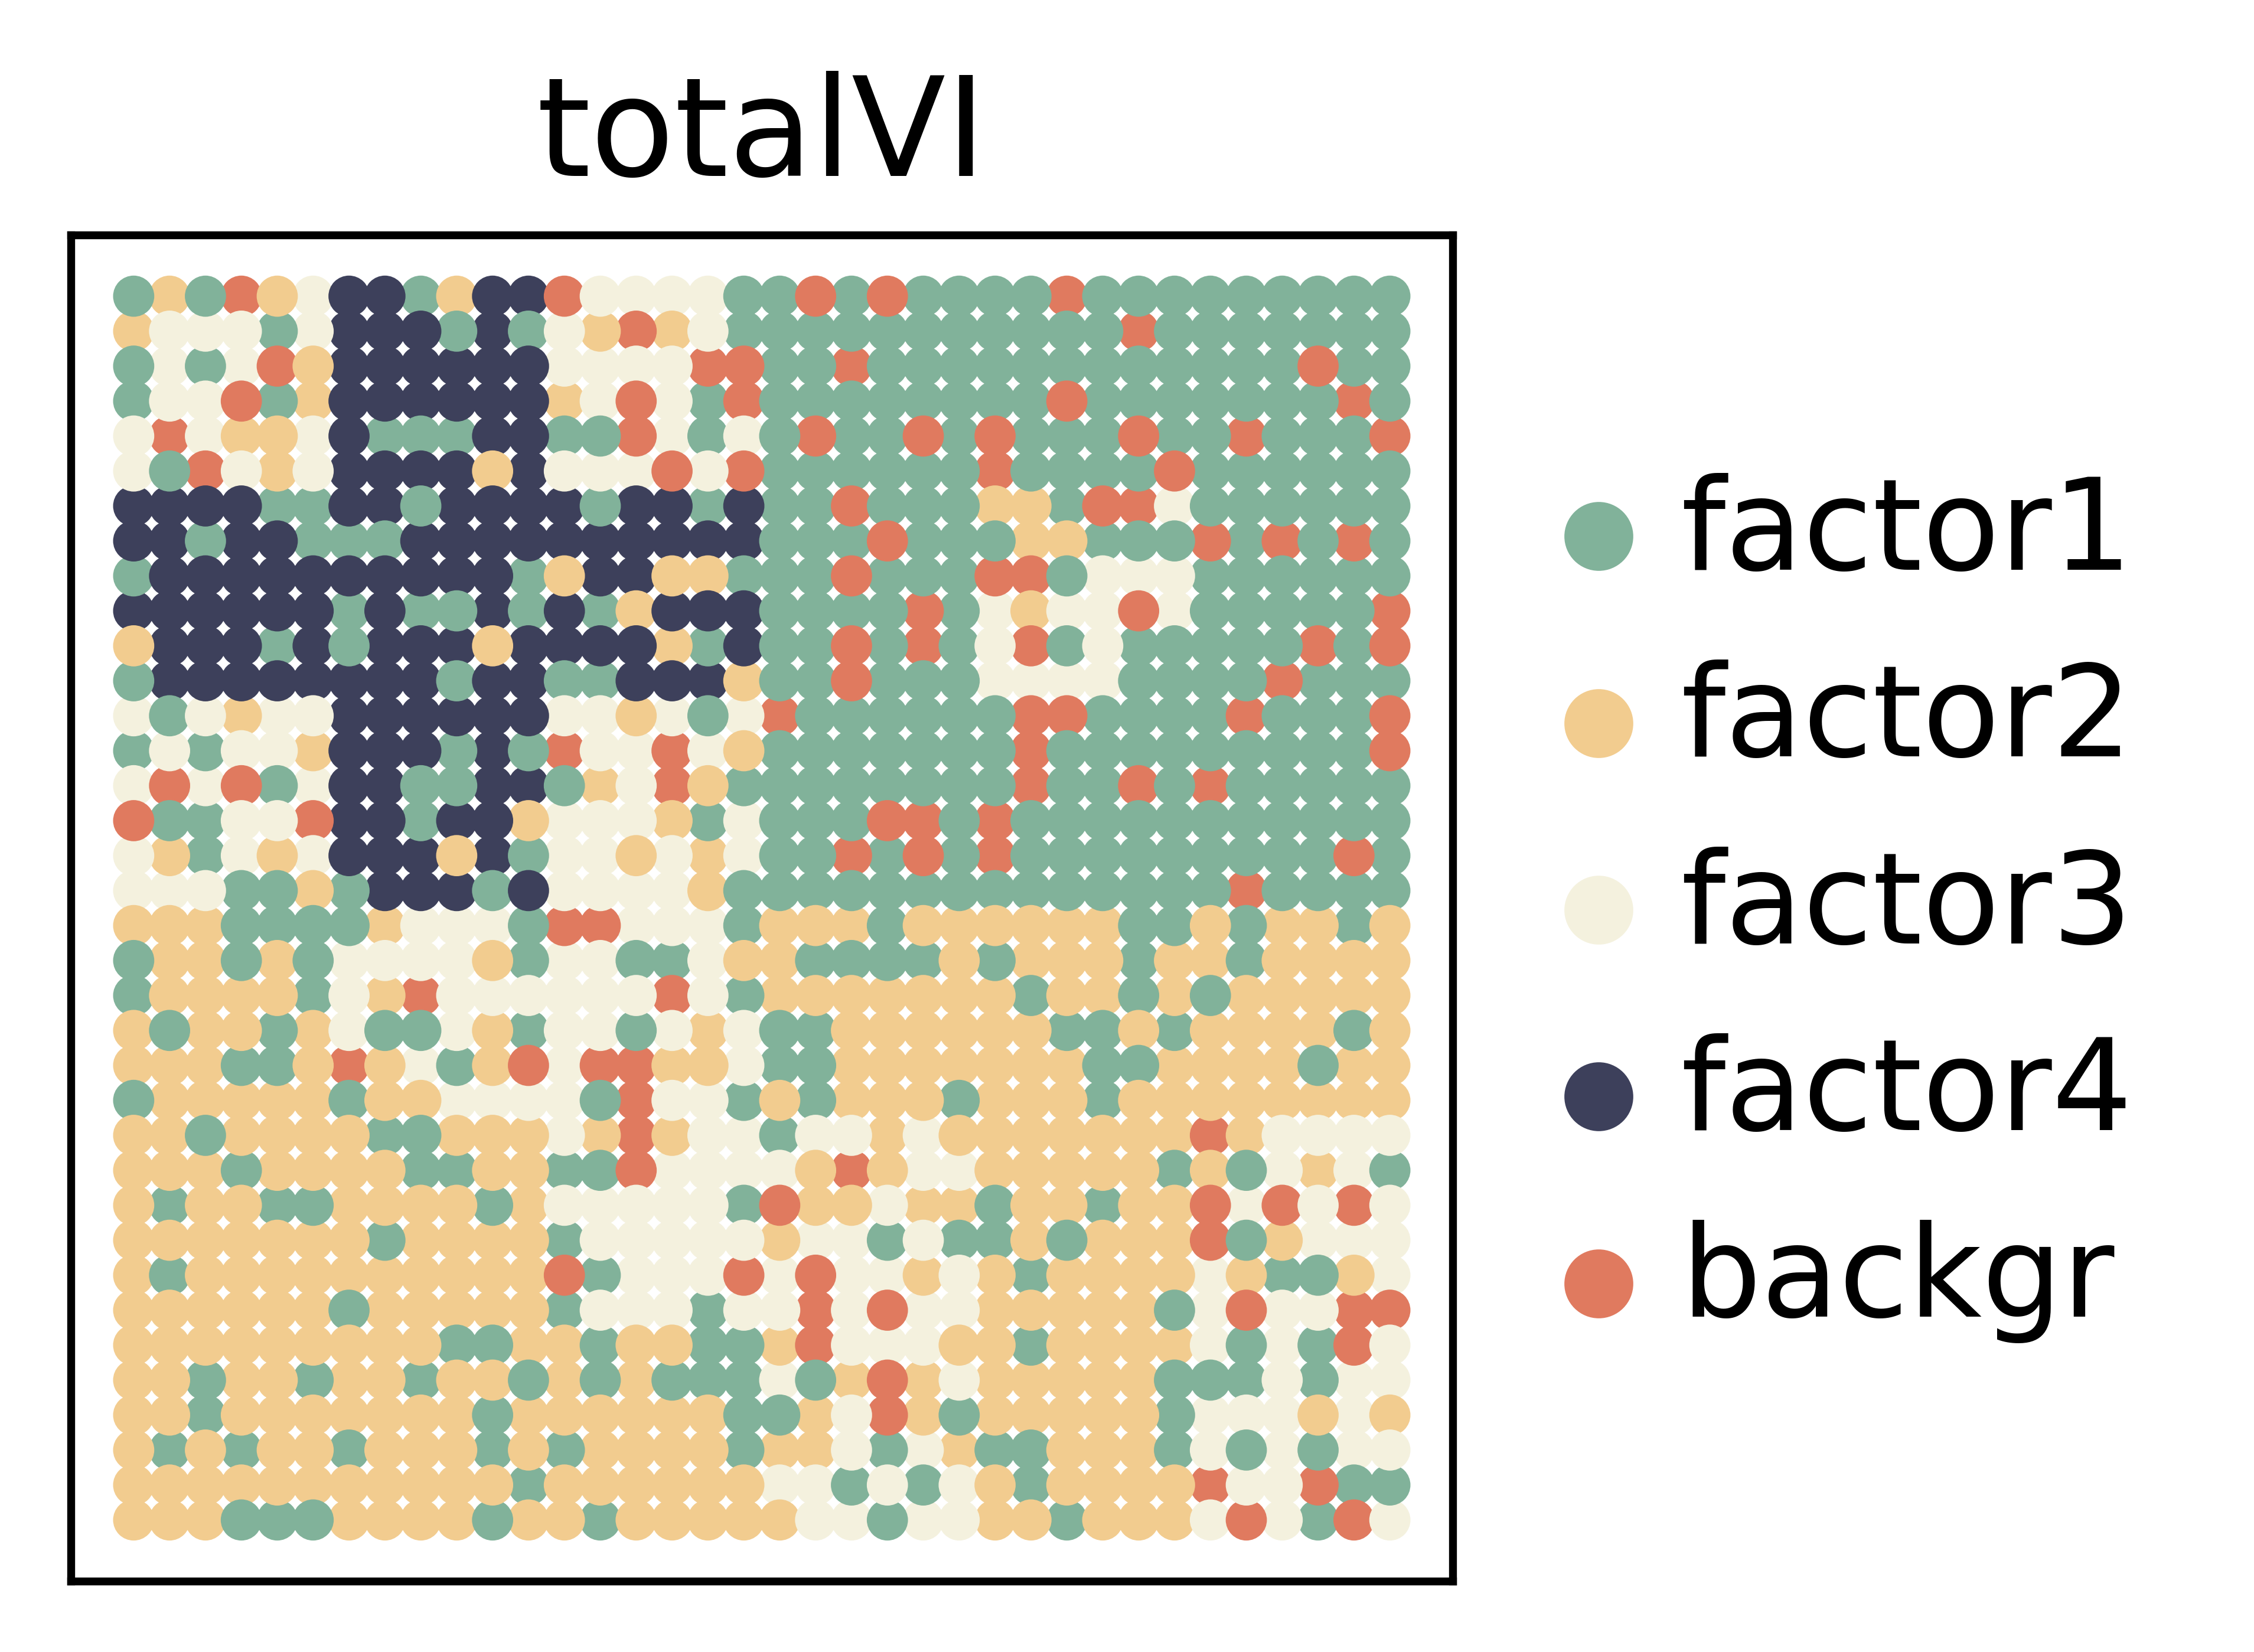

In [38]:
plt.rcParams['figure.figsize'] = (2.5,2.5)
plt.rcParams['font.size'] = 15
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['figure.dpi'] = 600

sc.pl.embedding(rna, basis='spatial', color='leiden', 
                title='totalVI', s=70, show=False,palette=custom_palette)
plt.xlabel('')
plt.ylabel('')


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0, 0.5, '')

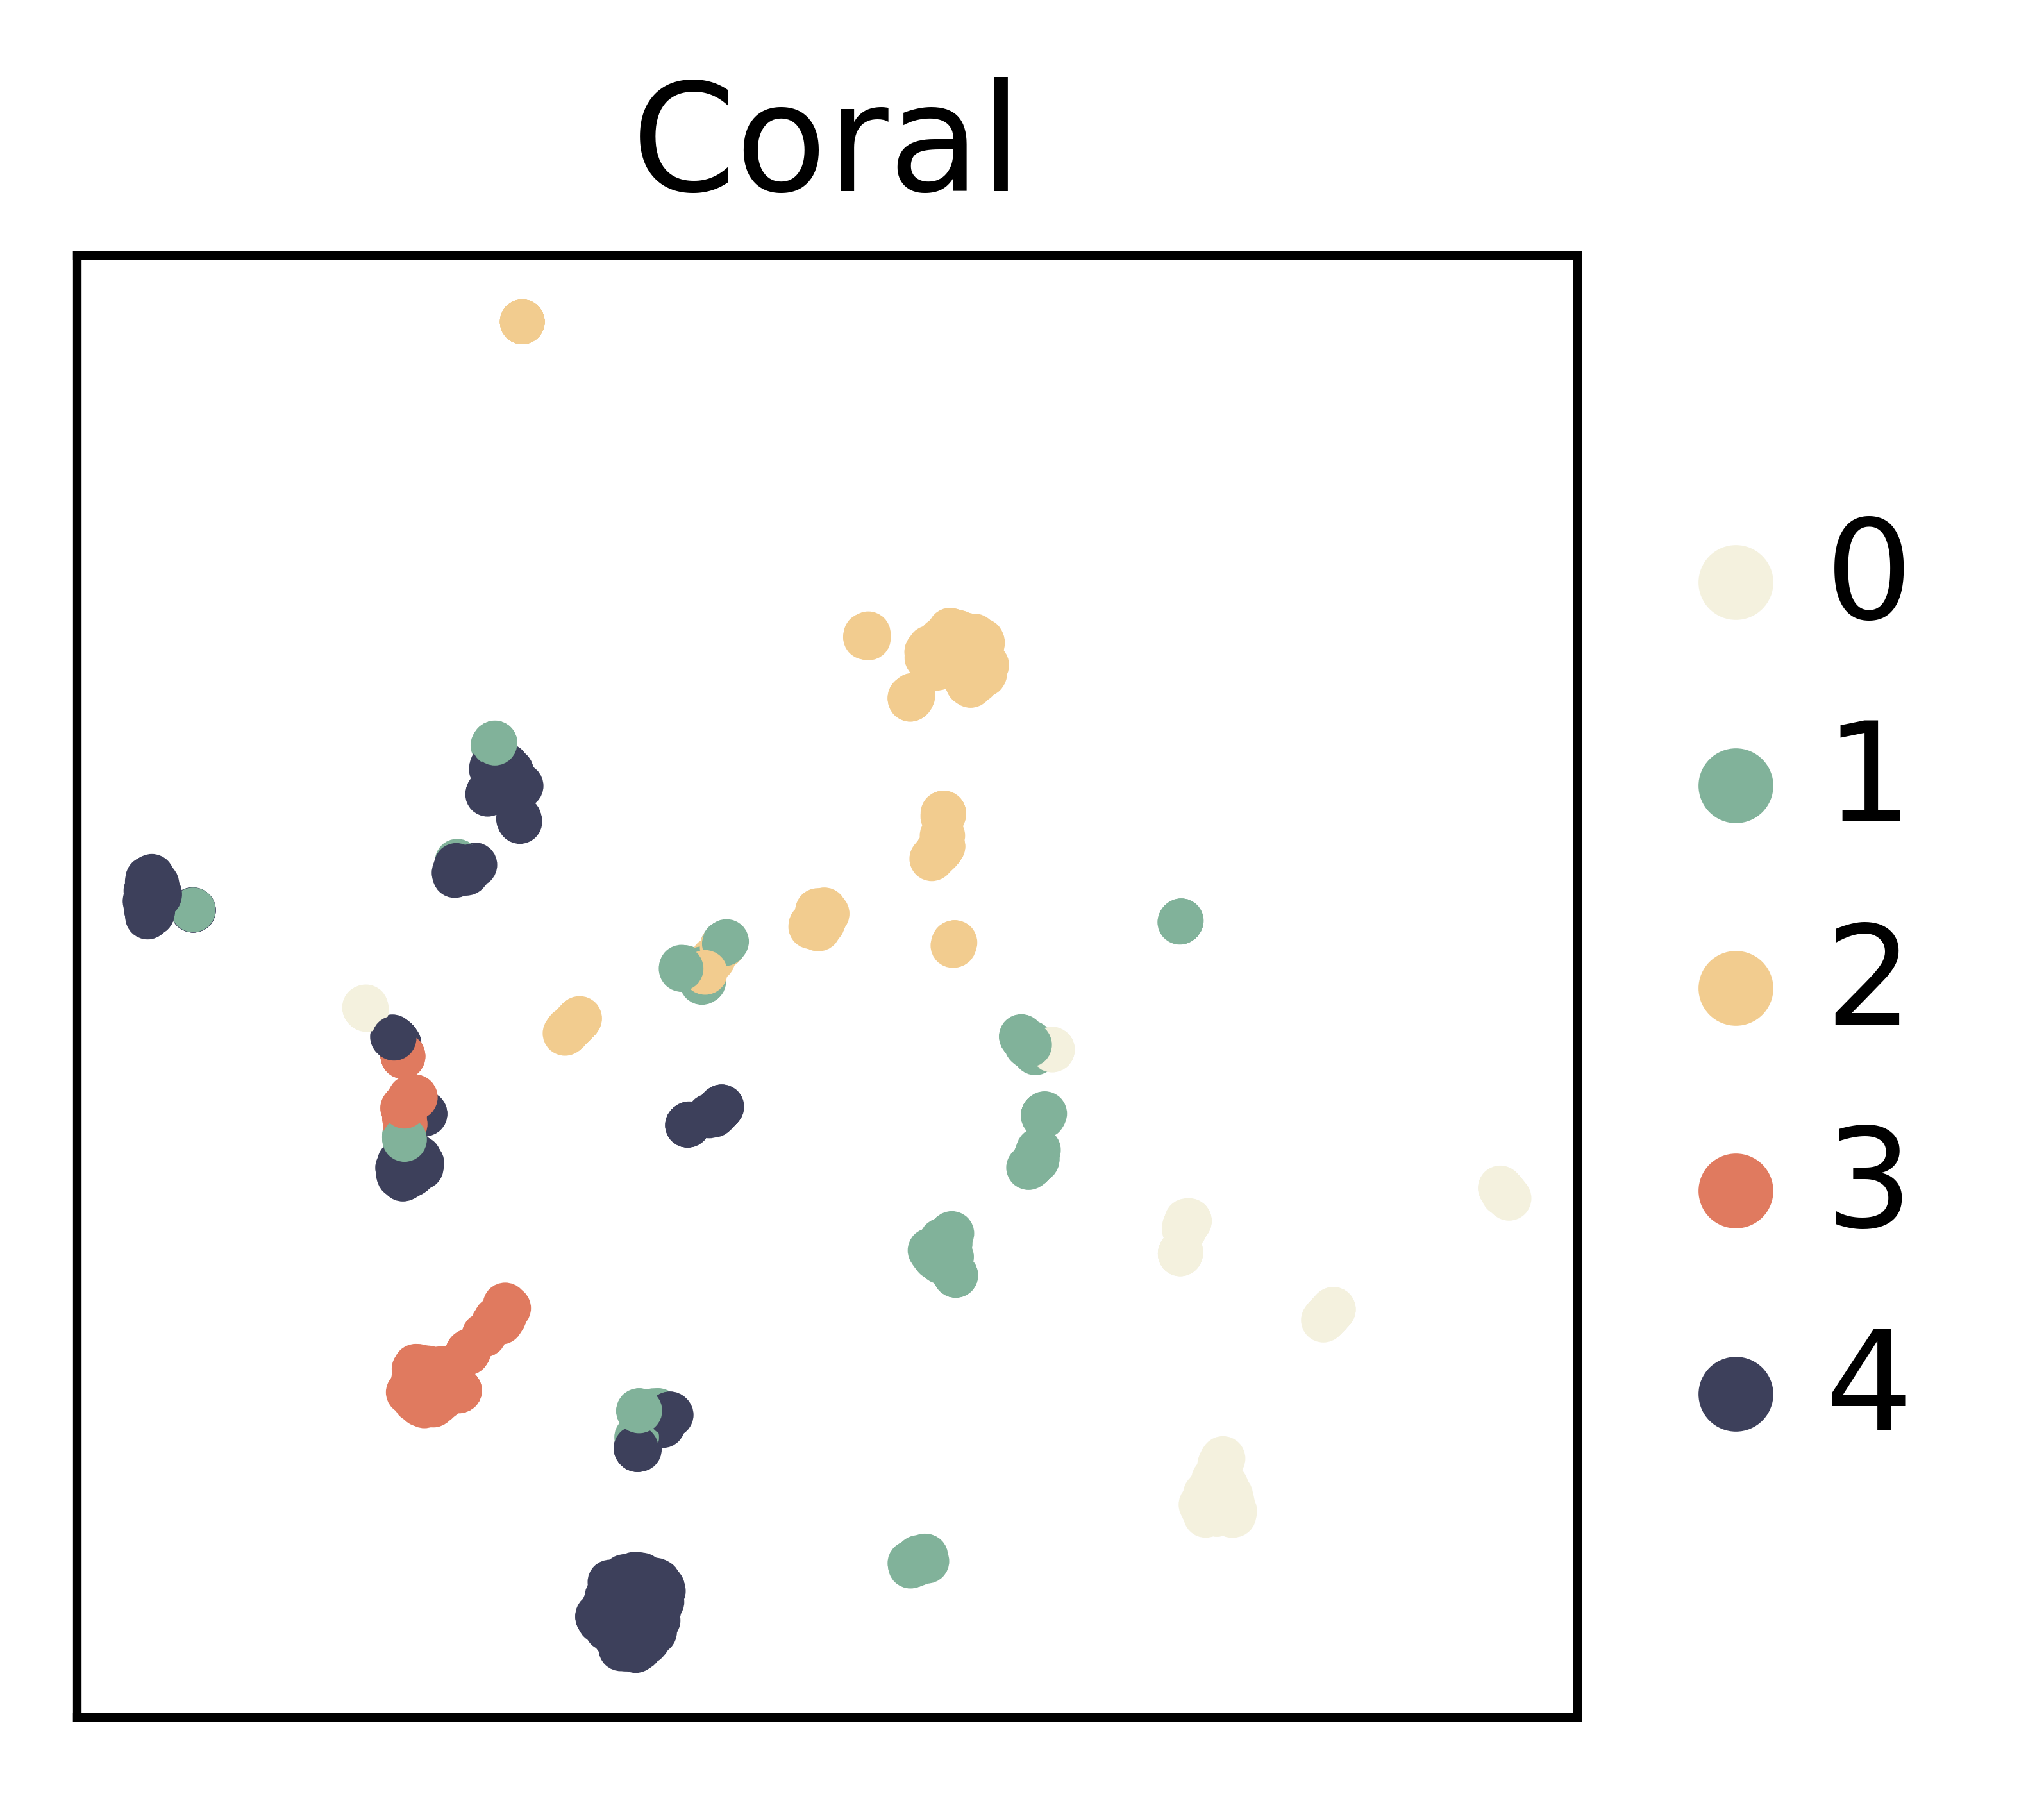

In [39]:
from umap import UMAP
umap_model = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Fit the model to your data and transform it
z_umap = umap_model.fit_transform(vae.get_latent_representation())
rna.obsm['umap'] = z_umap 

custom_palette = ['#f4f1de',  '#81b29a', '#f2cc8f', '#e07a5f','#3d405b',]

sc.pl.embedding(rna, basis='umap', title='Coral', color='cluster', s=70, show=False, palette=custom_palette)
plt.xlabel('')
plt.ylabel('')


Text(0, 0.5, '')

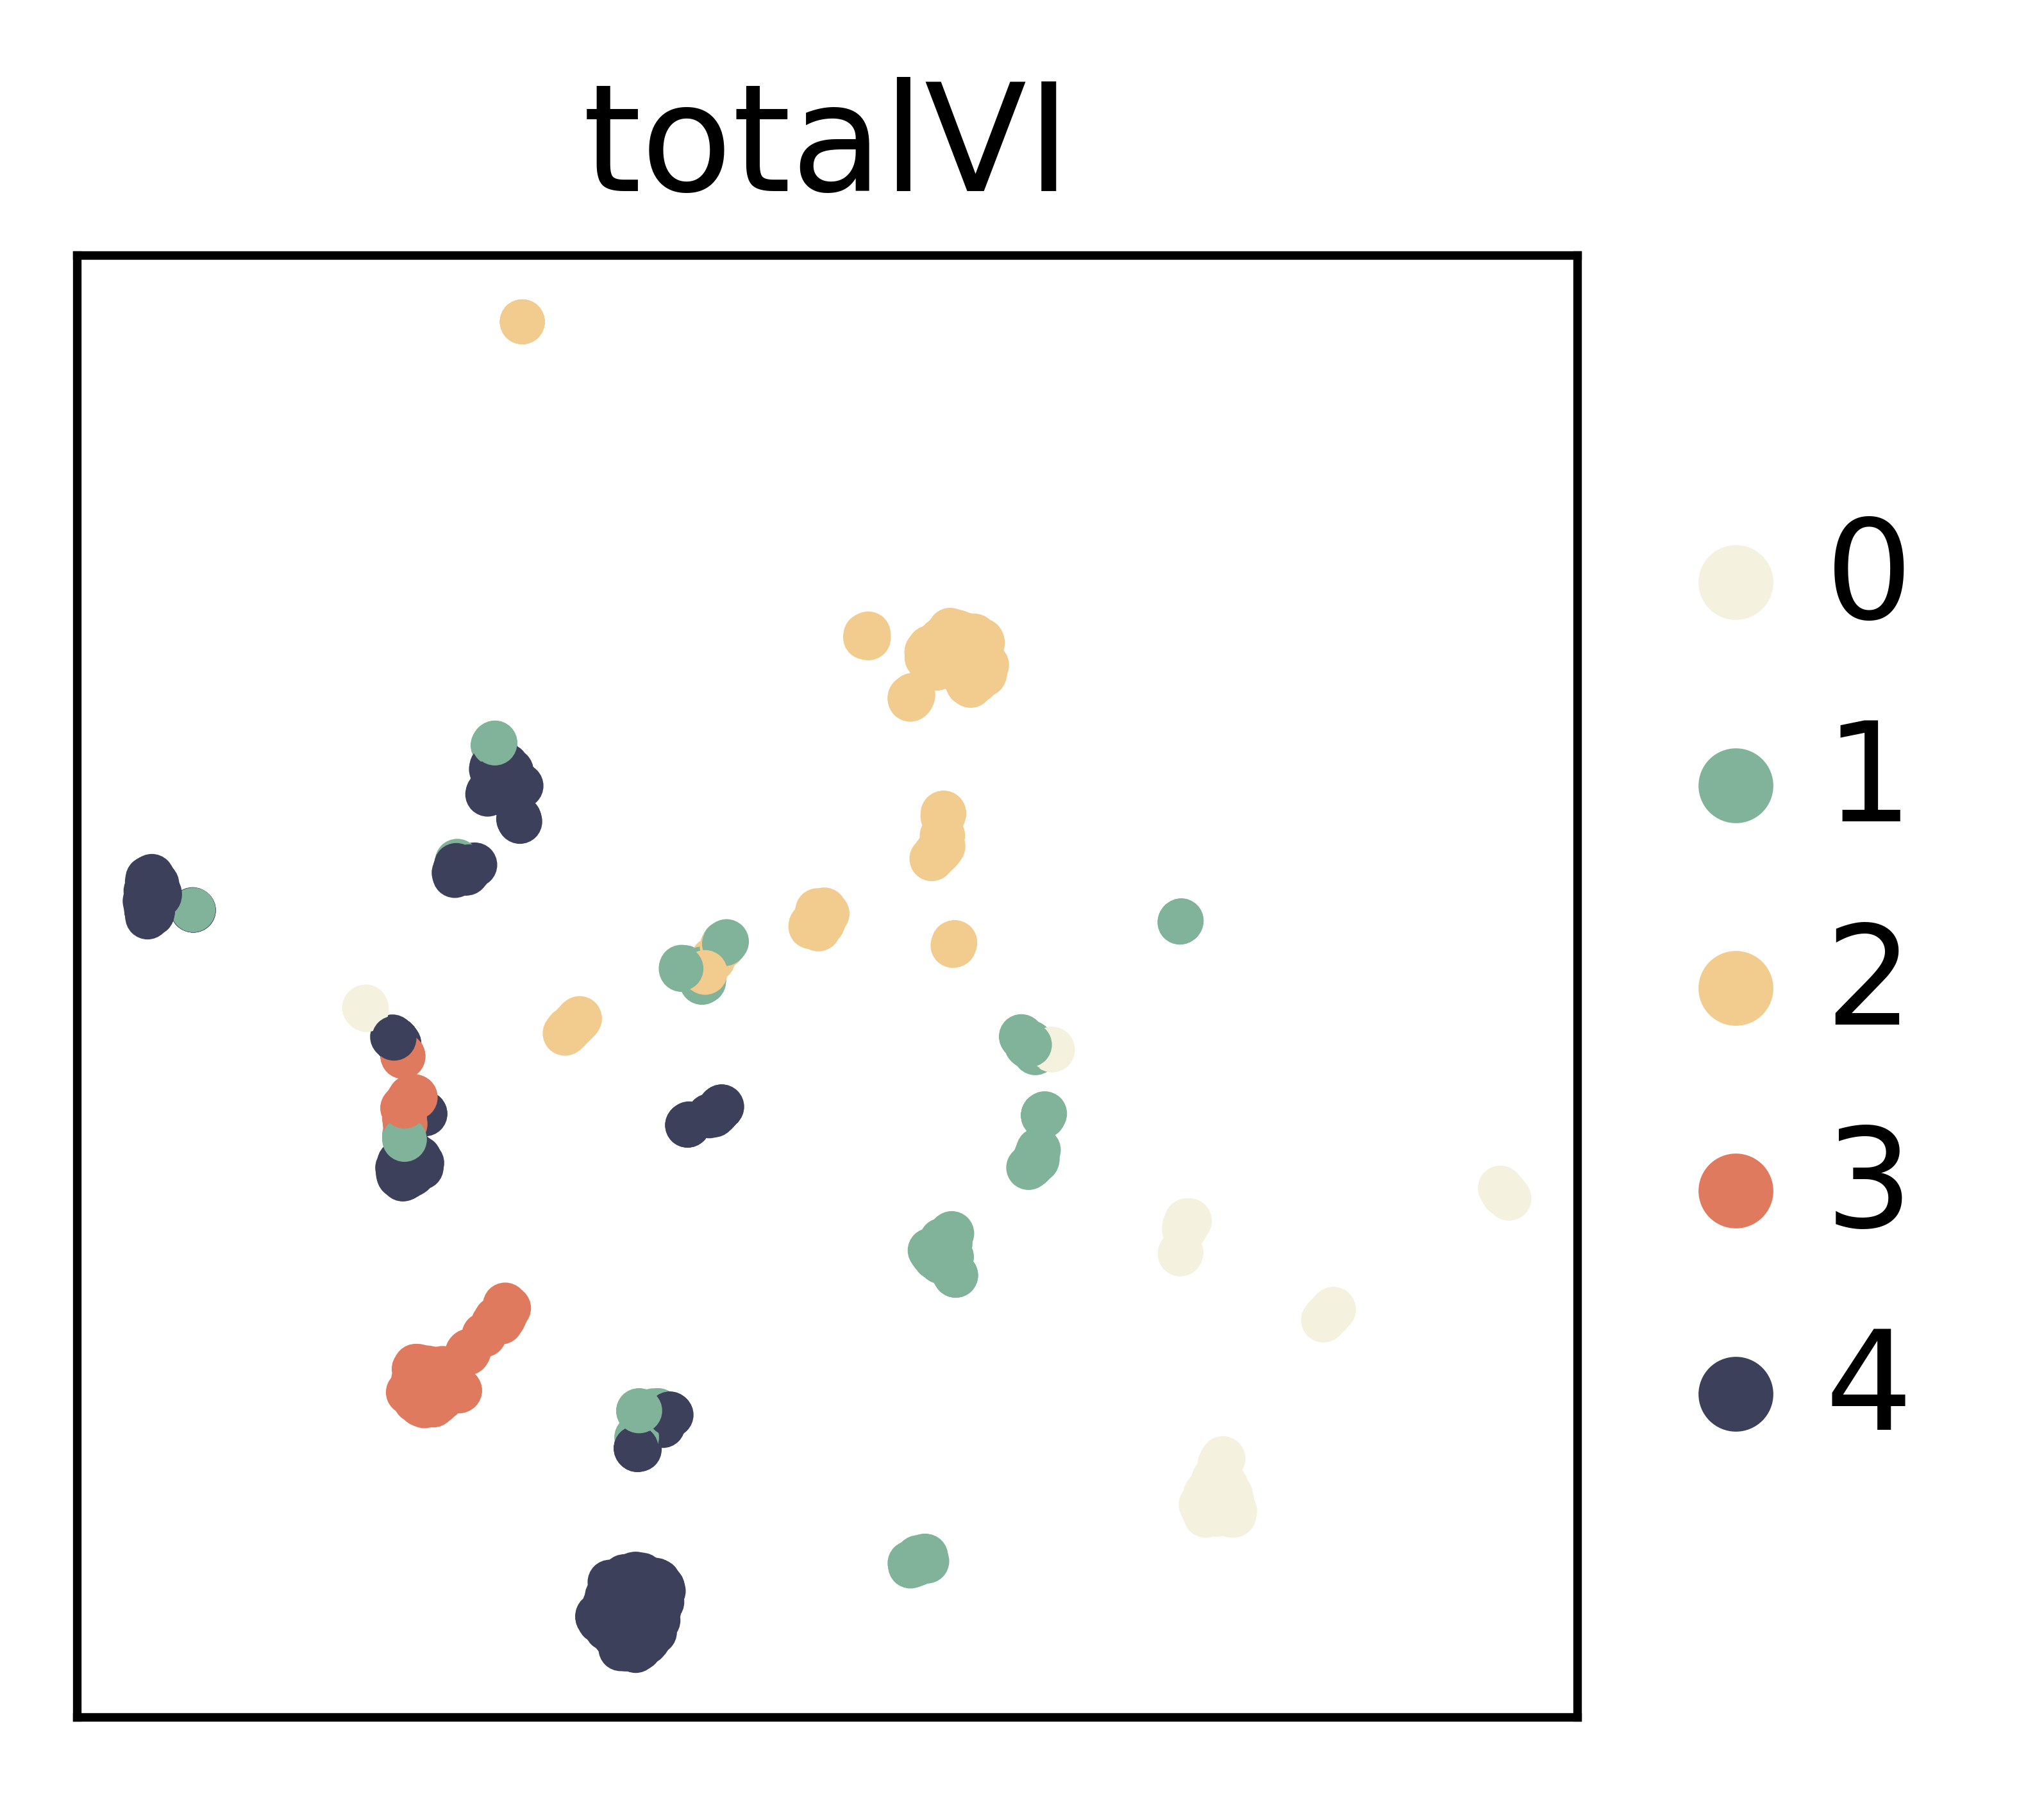

In [40]:
sc.pl.embedding(rna, basis='umap', title='totalVI', color='cluster', s=70, show=False, palette=custom_palette)
plt.xlabel('')
plt.ylabel('')


<Axes: title={'center': 'SpatialGlue'}, xlabel='spatial1', ylabel='spatial2'>

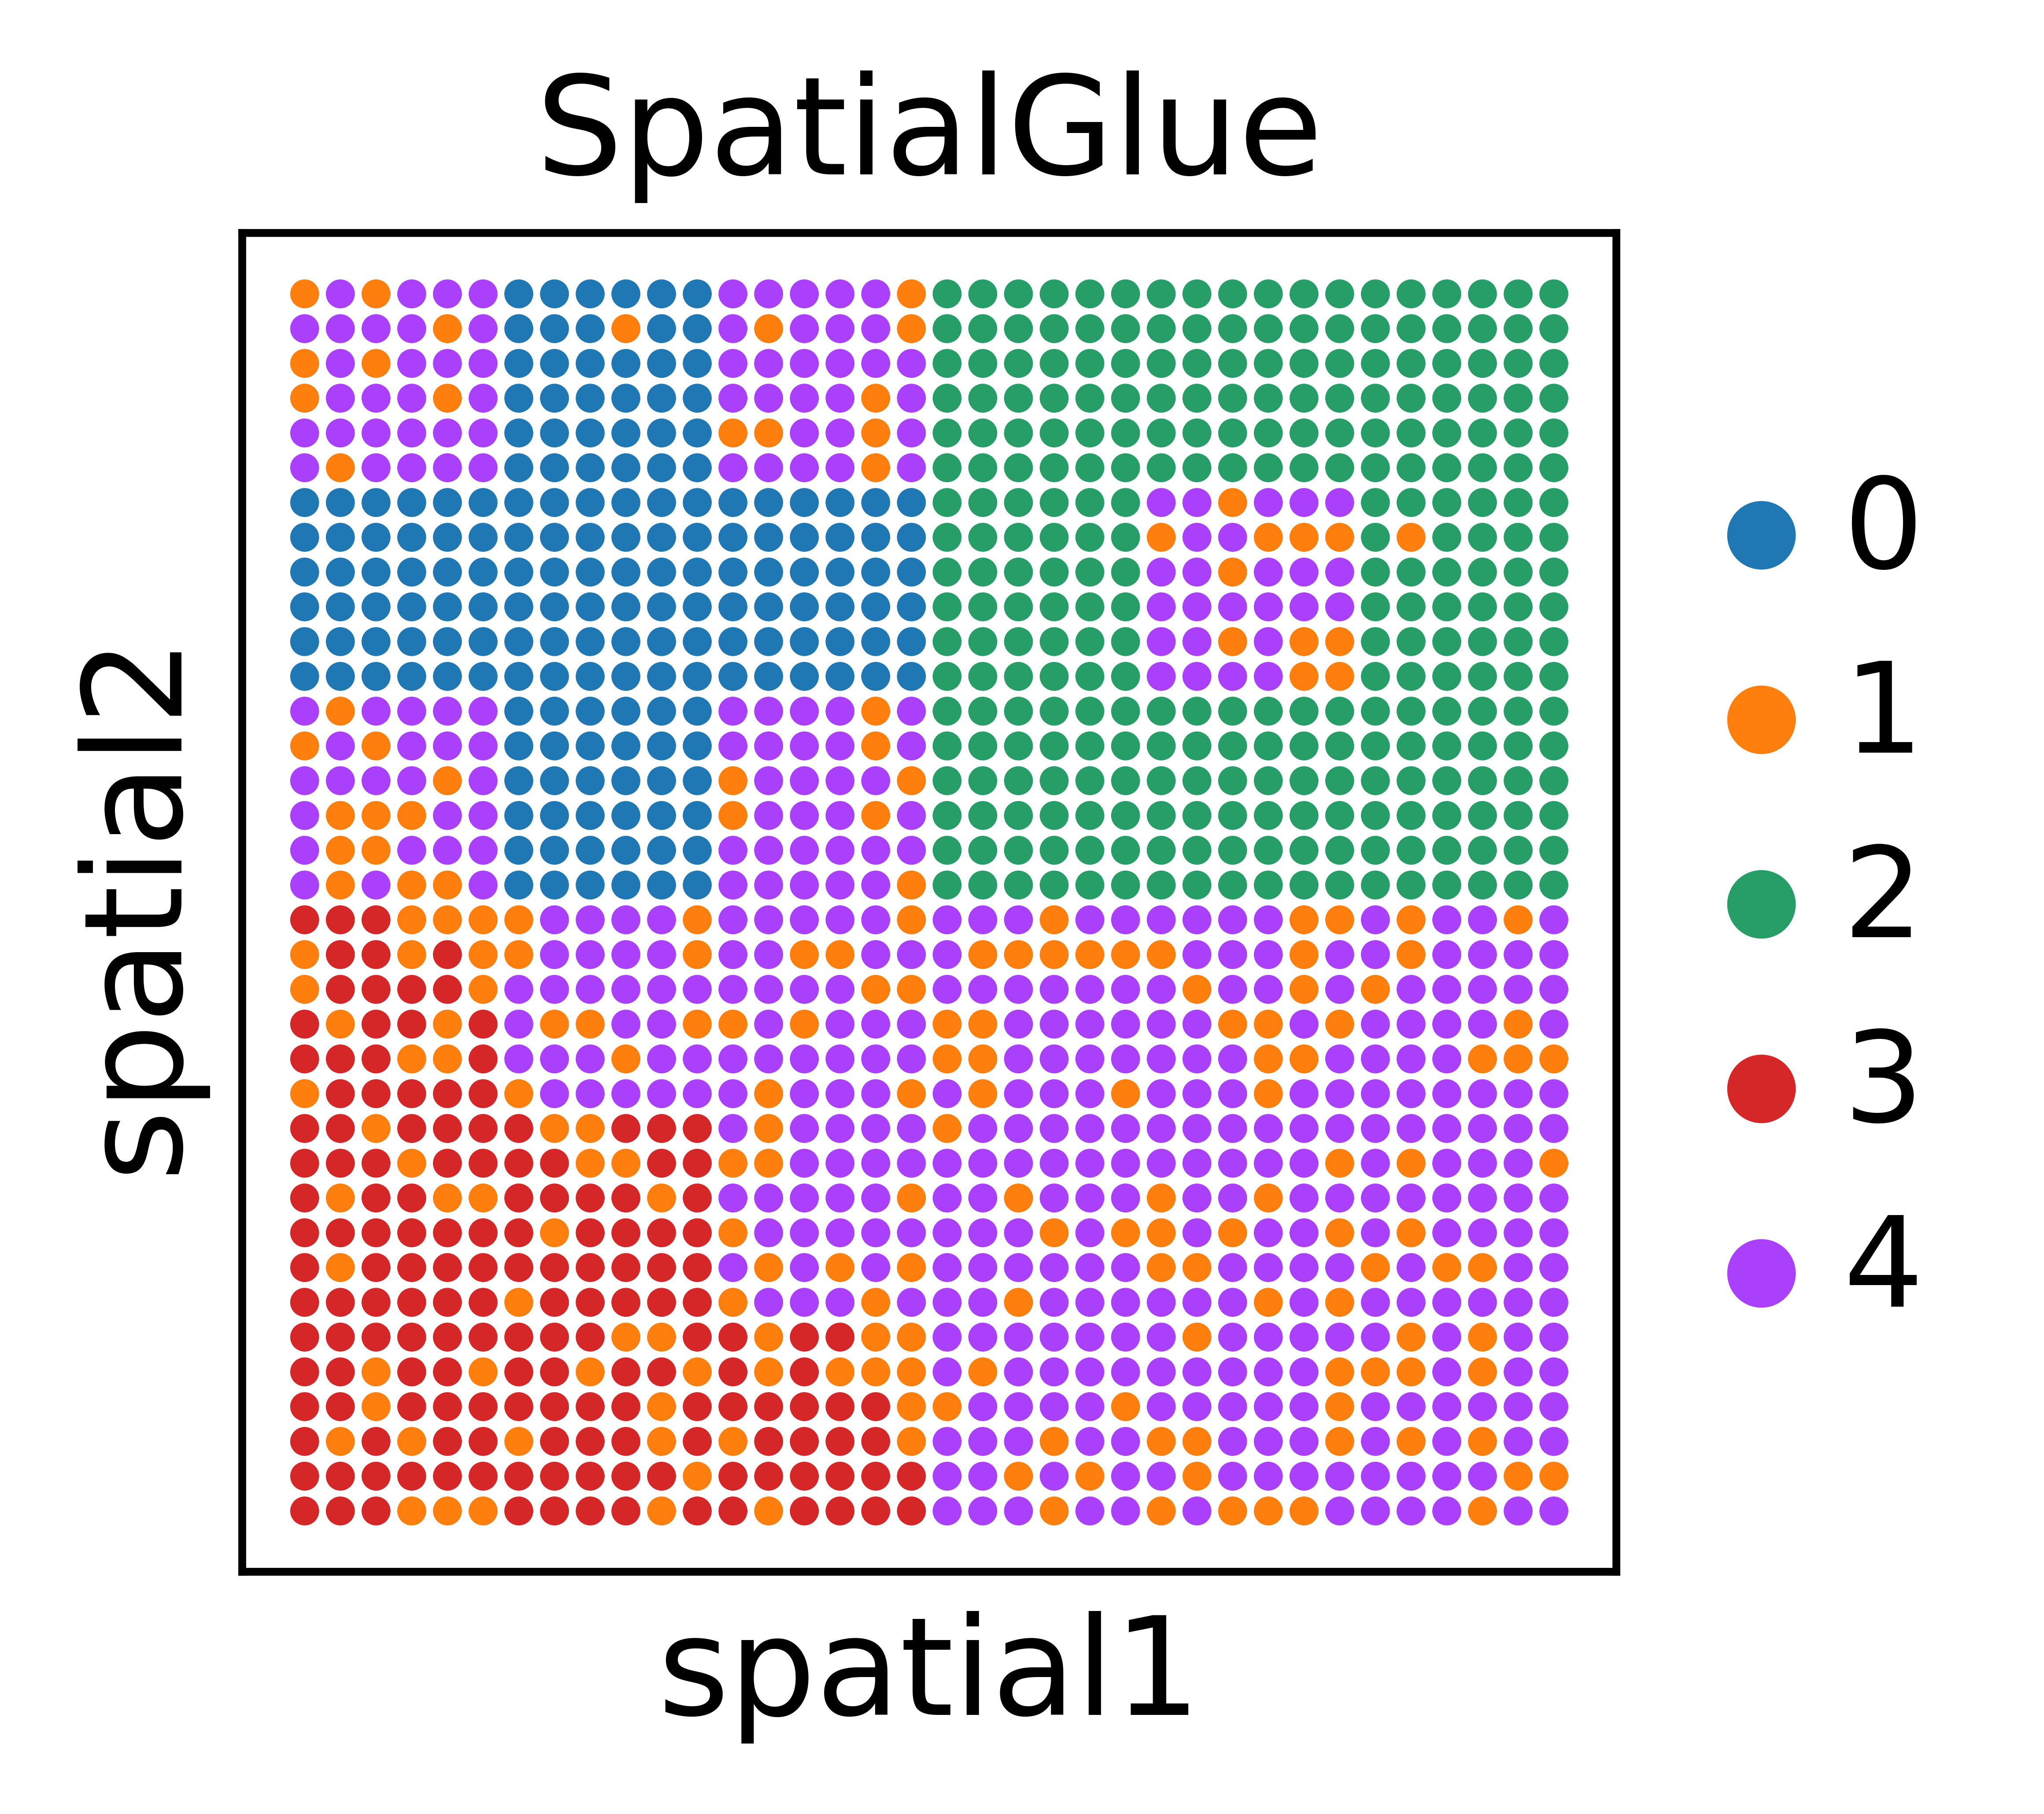

In [22]:
sc.pl.embedding(rna, basis='spatial', color='cluster', 
                title='SpatialGlue', s=35, show=False)

In [41]:
rna.write('/hpc/mydata/siyu.he/coral_storage/coral_results/simulation/totalvi_simu1.h5ad')